## README
Please run the cells in order since some variables storing the values of mu and sigma are being re-used in both questions 2 and 3.

In [ ]:
%%capture
# For installing latex packages to render plot labels
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [ ]:
%reset -f

import torch as tor
import matplotlib.pyplot as plt
import numpy as np
tor.manual_seed(3) # setting random seed
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [ ]:
'''
  plots mu and sigma^2
'''
def plot_mu_sigma_squared(mus, sigmas):
  plt.plot(mus)
  plt.yticks(np.arange(-2,2.5,0.5)) # setting limits of axis
  plt.ylim(-2, 2)
  plt.ylabel("$\mu$", rotation=0, fontsize=24, labelpad=15)
  plt.figure()
  plt.plot(sigmas)
  plt.ylabel("$\sigma^2$", rotation=0, fontsize=24, labelpad=15)
  plt.yticks(np.arange(0,2.25,0.25))
  plt.ylim(0, 2)
  plt.figure()
  plt.show()

'''
  plots sample estimates of gradients with respect to mu and sigma^2 and
  their true gradients
'''
def plot_grad_mu_sigma_squared(grad_wrt_mu, true_grad_mu, grad_wrt_sigma, true_grad_sigma):
  plt.plot(grad_wrt_mu)
  plt.axhline(y=true_grad_mu, linestyle="--")
  plt.yticks(np.arange(-4,0.5,0.5))
  plt.ylim(-4, 0)
  plt.ylabel("$-\\frac{\\partial \widehat{\mathcal{J}({\\theta})} }{\\partial \mu}$", rotation=0, fontsize=20, labelpad=35)
  plt.figure()
  plt.plot(grad_wrt_sigma)
  plt.ylabel("$-\\frac{\\partial \widehat{\mathcal{J}({\\theta})} }{\\partial \log{(\sigma^2)}}$", rotation=0, fontsize=20, labelpad=40)
  plt.axhline(y=true_grad_sigma, linestyle="--")
  plt.yticks(np.arange(1,4.5,0.5))
  plt.ylim(1, 4)
  plt.figure()
  plt.show()


In [ ]:
# Setting values used in both questions 2 and 3
act_dim = 1 # number of actions
astar = tor.tensor([+1]) # value of a*

# Question 2: (a) and (b)

In [ ]:
# Part a and b
mu = tor.tensor([0.0], requires_grad=True)
log_sigma = tor.tensor([0.0], requires_grad=True) # log sigma^2
opt = tor.optim.SGD([mu, log_sigma], lr=0.001)

# Experiment
T = 10000
mus = tor.zeros(T, act_dim)
sigmas = tor.zeros(T, act_dim) # sigma^2
for t in range(T):
    # Interaction
    pol = tor.distributions.MultivariateNormal(mu, tor.diag(tor.exp(log_sigma))) # computational model of policy
    A = pol.sample() # sample action from policy
    R = -tor.norm(A-astar)**2 + tor.randn(1)
    # Compute loss
    sur_obj = pol.log_prob(A)*R
    loss = -sur_obj
    # Update
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Collect data
    mus[t] = mu.data.clone()
    sigmas[t] = tor.exp(log_sigma.data.clone())

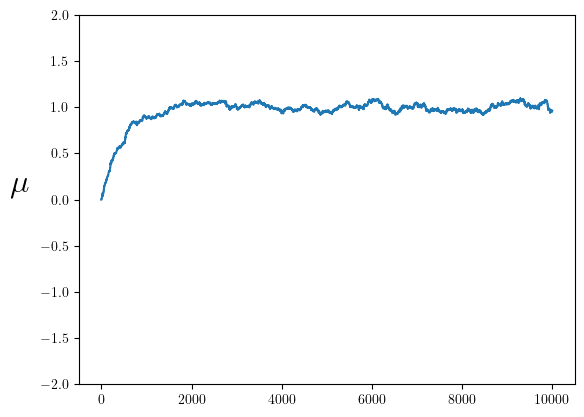

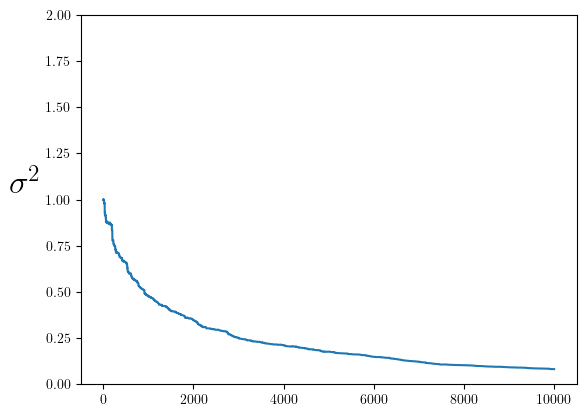

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the results
plot_mu_sigma_squared(mus, sigmas)


# Question 2: (c) and (d)


In [ ]:
mu = tor.tensor([0.0], requires_grad=True)
log_sigma = tor.tensor([1.0], requires_grad=True) # sigma^2 = e => log sigma^2 = 1

# Experiment
T = 10000
grad_j_wrt_mu = tor.zeros(T, act_dim)
grad_j_wrt_var = tor.zeros(T, act_dim)
cumulative_avg_mu = tor.zeros(T, act_dim)
cumulative_avg_sigma = tor.zeros(T, act_dim)
true_obj = - (mu - astar)**2 - tor.exp(log_sigma)
true_obj.backward()
true_grad_mu = -mu.grad
true_grad_sigma = -log_sigma.grad
mu.grad.data.zero_()
for t in range(T):
    # Interaction
    pol = tor.distributions.MultivariateNormal(mu, tor.diag(tor.exp(log_sigma)))
    A = pol.sample()
    R = -tor.norm(A-astar)**2 + tor.randn(1)
    sur_obj = pol.log_prob(A)*R
    # take gradient of J
    sur_obj.backward()
    grad_j_wrt_mu[t] = -1 * mu.grad
    cumulative_avg_mu[t] = tor.mean(grad_j_wrt_mu[:t + 1], dim=0)
    grad_j_wrt_var[t] = -1 * log_sigma.grad
    cumulative_avg_sigma[t] = tor.mean(grad_j_wrt_var[:t + 1], dim=0)
    # Reset gradients
    mu.grad.data.zero_()
    log_sigma.grad.data.zero_()


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


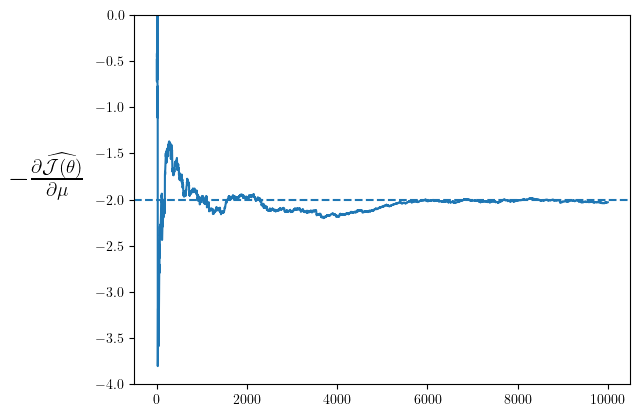

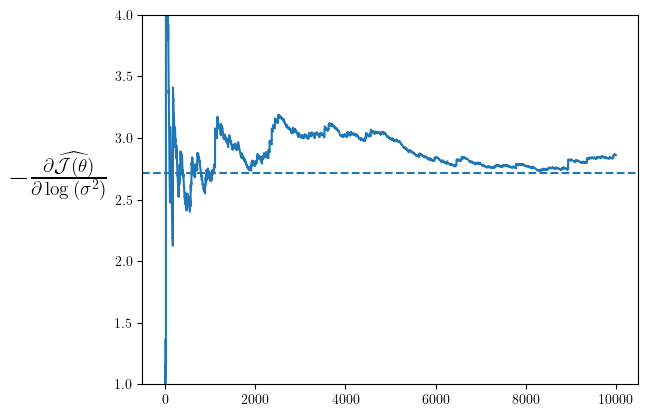

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the results
plot_grad_mu_sigma_squared(cumulative_avg_mu, true_grad_mu, cumulative_avg_sigma, true_grad_sigma)

# Question 3: (a) and (b)

In [ ]:
# Solution
mu = tor.tensor([0.0], requires_grad=True)
log_sigma = tor.tensor([0.0], requires_grad=True) # log sigma^2
opt = tor.optim.SGD([mu, log_sigma], lr=0.001)

# Experiment
T = 10000
mus = tor.zeros(T, act_dim)
sigmas = tor.zeros(T, act_dim) # sigma^2
for t in range(T):
    pol = tor.distributions.MultivariateNormal(mu, tor.diag(tor.exp(log_sigma))) # policy
    A = pol.rsample() # reparameterized action sample
    R = -(A-astar)**2 # true reward
    # Compute loss
    sur_obj = R
    loss = -sur_obj
    # Update
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Record data
    mus[t] = mu.data.clone()
    sigmas[t] = tor.exp(log_sigma.data.clone())


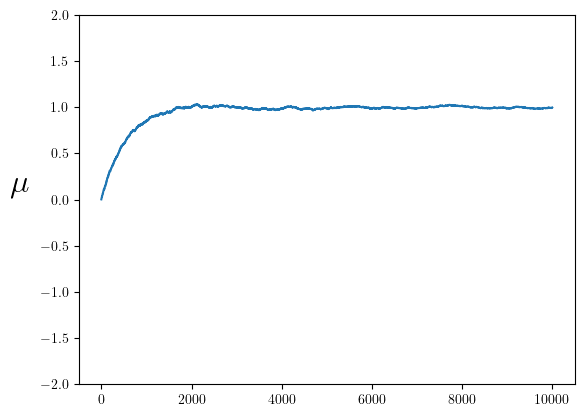

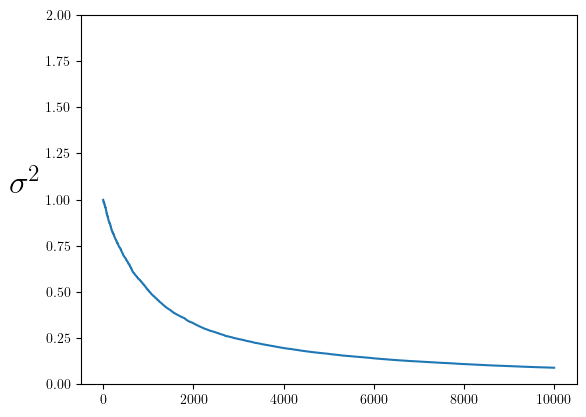

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_mu_sigma_squared(mus, sigmas)

# Question 3 : (c) and (d)

In [ ]:
# Problem
act_dim = 1
astar = tor.tensor([+1])

# Solution
mu = tor.tensor([0.0], requires_grad=True)
log_sigma = tor.tensor([1.0], requires_grad=True) # sigma^2 = e => log sigma^2 = 1

# Experiment
T = 10000
mus = tor.zeros(T, act_dim)
sigmas = tor.zeros(T, act_dim) # this is really sigma^2
grad_j_wrt_mu = tor.zeros(T, act_dim)
grad_j_wrt_var = tor.zeros(T, act_dim)
cumulative_avg_mu = tor.zeros(T, act_dim)
cumulative_avg_sigma = tor.zeros(T, act_dim)
true_obj = - (mu - astar)**2 - tor.exp(log_sigma)
true_obj.backward()
true_grad_mu = -mu.grad # true gradient wrt mu
true_grad_sigma = -log_sigma.grad # true gradient with respect to log sigma^2
mu.grad.data.zero_()
for t in range(T):
    # Interaction
    pol = tor.distributions.MultivariateNormal(mu, tor.diag(tor.exp(log_sigma)))
    A = pol.rsample()
    R = -(A-astar)**2
    sur_obj = R
    sur_obj.backward()
    # Log
    grad_j_wrt_mu[t] = -1 * mu.grad

    cumulative_avg_mu[t] = tor.mean(grad_j_wrt_mu[:t + 1], dim=0)
    grad_j_wrt_var[t] = -1 * log_sigma.grad
    cumulative_avg_sigma[t] = tor.mean(grad_j_wrt_var[:t + 1], dim=0)
    # Reset gradient values
    mu.grad.data.zero_()
    log_sigma.grad.data.zero_()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


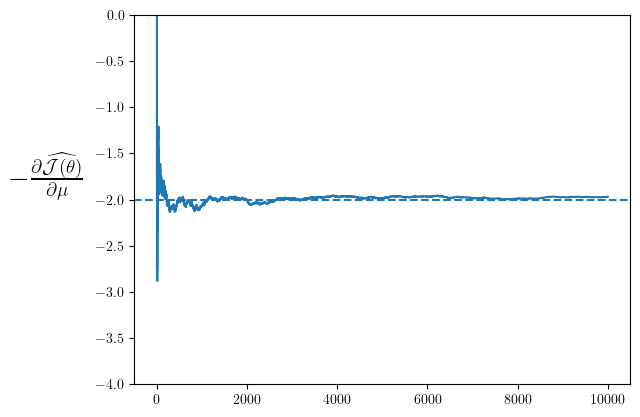

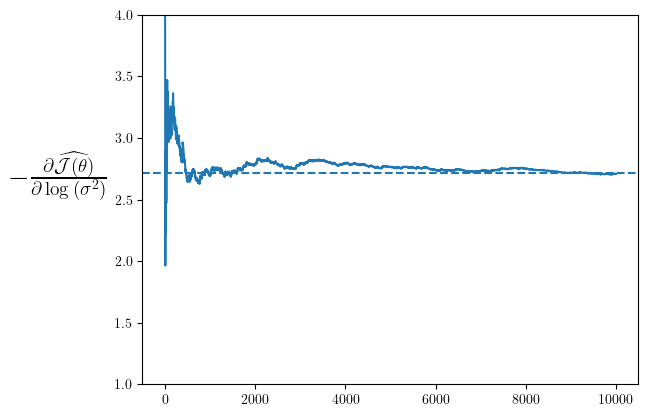

<Figure size 640x480 with 0 Axes>

In [ ]:

plot_grad_mu_sigma_squared(cumulative_avg_mu, true_grad_mu, cumulative_avg_sigma, true_grad_sigma)